In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,8)
#matplotlib.rcParams['figure.figsize'] = (20,20)
matplotlib.rcParams['font.size'] = 32
matplotlib.rcParams['legend.fontsize'] = 32
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from sklearn import linear_model


def subsample(t, granularity):
    if granularity > 1.0 or granularity <= 0:
        raise ValueError("granularity must be in ]0, 1]")
    t0 = 0
    n_samples = int(np.ceil(granularity * t))
    if n_samples == 1:
        return [t]
    else:
        return np.linspace(t0, t, n_samples, dtype=int)
    
def mean_increment(money):
    d = np.diff(money)
    increments = [i for i in d if i != 0]
    if len(increments) > 0:
        return np.mean(increments)
    else:
        return 0

In [2]:
sk = Sidekick()
sk.load()
successful = sk.successful()
failed = sk.failed()
projects_train, projects_test = sk.split(threshold=0.7)

Loading data set...
Data loaded.


In [22]:
outlier_threshold = 10000
normalized = False

for p in np.append(projects_train, projects_test):
    p.normalized = normalized

projects_train_filtered = [p for p in projects_train if np.all([(m - outlier_threshold) <= 0 for m in p.money])]
projects_test_filtered = [p for p in projects_test if np.all([(m - outlier_threshold) <= 0 for m in p.money])]

print("Keeping %.2f%% of data" % (len(projects_train_filtered) / len(projects_train) * 100))

Keeping 83.97% of data


Linear regression: f(x) = 1153.63 + 3.17x
Successful (train): 3775 (40.40%)
Failed (train): 5570 (59.60%)
Successful (test): 1604 (39.97%)
Failed (test): 2409 (60.03%)


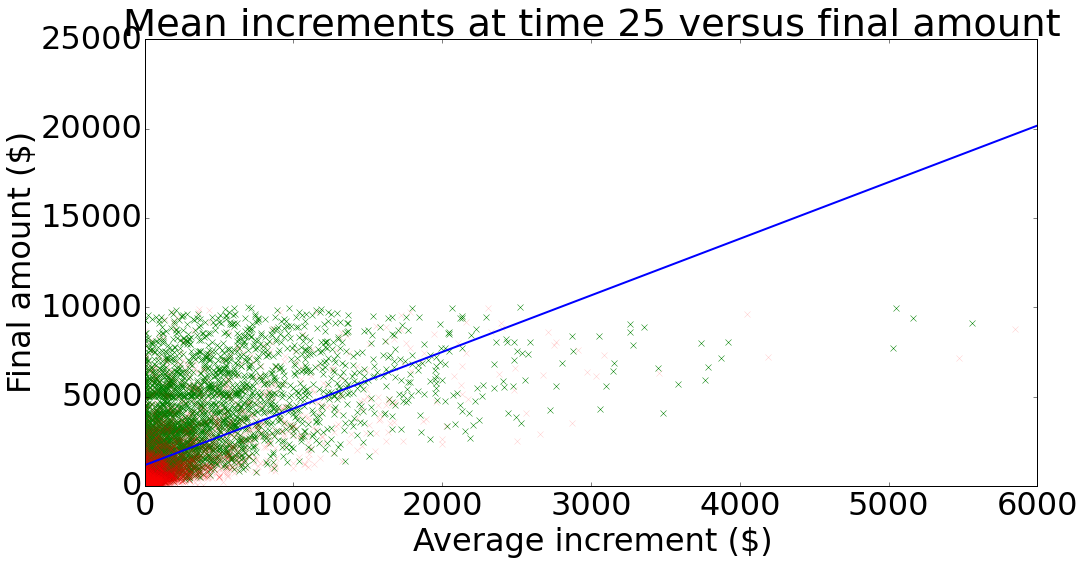

In [35]:
t = 25
granularity = 1
samples = subsample(t, granularity)
n_samples = 1

T = 999
standardize = False
extractor1 = lambda a: a[t-1]
extractor2 = lambda a: a[t-1] / t
extractor3 = lambda a: mean_increment(a)
extractor4 = lambda a: np.max(np.diff(a))

processing = extractor1

X_train = np.ndarray(shape=(len(projects_train_filtered), n_samples), buffer=np.array([processing(p.money[samples]) for p in projects_train_filtered]), dtype=float)
y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
X_test = np.ndarray(shape=(len(projects_test_filtered), n_samples), buffer=np.array([processing(p.money[samples]) for p in projects_test_filtered]), dtype=float)
y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)

X_train_successful = [processing(p.money[samples]) for p in projects_train_filtered if p.successful]
y_train_successful = [p.money[T] for p in projects_train_filtered if p.successful]
X_train_failed = [processing(p.money[samples]) for p in projects_train_filtered if not p.successful]
y_train_failed = [p.money[T] for p in projects_train_filtered if not p.successful]

X_test_successful = [processing(p.money[samples]) for p in projects_test_filtered if p.successful]
y_test_successful = [p.money[T] for p in projects_test_filtered if p.successful]
X_test_failed = [processing(p.money[samples]) for p in projects_test_filtered if not p.successful]
y_test_failed = [p.money[T] for p in projects_test_filtered if not p.successful]    

if standardize:
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std
    
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print('Linear regression: f(x) = %0.2f + %0.2fx' % (regr.intercept_[0], regr.coef_[0, 0]))

print("Successful (train): %s (%.2f%%)" % (len(X_train_successful), len(X_train_successful) / len(projects_train_filtered) * 100))
print("Failed (train): %s (%.2f%%)" % (len(X_train_failed), len(X_train_failed) / len(projects_train_filtered) * 100))

print("Successful (test): %s (%.2f%%)" % (len(X_test_successful), len(X_test_successful) / len(projects_test_filtered) * 100))
print("Failed (test): %s (%.2f%%)" % (len(X_test_failed), len(X_test_failed) / len(projects_test_filtered) * 100))

plt.plot(X_train_successful, y_train_successful, 'xg')
plt.plot(X_train_failed, y_train_failed, 'xr', alpha=0.2)

#plt.plot(X_train, y_train, 'xb')

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_ + regr.intercept_
plt.plot(x, y_pred[0], 'b-', lw=2)
plt.title("Mean increments at time %s versus final amount" % t)
plt.xlabel("Average increment ($)")
plt.ylabel("Final amount ($)")
plt.xlim([0, plt.xlim()[1]])
#plt.ylim([0, 1.5 * outlier_threshold])
plt.savefig("increments_t_%s_linear_regression.pdf" % t)
plt.show()

## Evaluate

In [36]:
se_successful = []
se_failed = []
se_total = []
accuracy = 0
for i, x_test in enumerate(X_test):
    if normalized:
        goal = 1
    else:
        p = projects_test_filtered[i]
        goal = float(p.goal)
    x_test = np.expand_dims(x_test, axis=0)
    #y_pred = x_test * regr.coef_ + regr.intercept_
    y_pred = regr.predict(x_test)
    y_pred = y_pred[0]
    y_actual = y_test[i][0]
    se = (y_pred - y_actual)**2
    se_total.append(se)
    if y_test[i] >= 1.0:  # Project is successful
        se_successful.append(se)
    else:  # project is failed
        se_failed.append(se)
    if normalized:
        if (y_pred >= 1 and y_actual >= 1) or (y_pred < 1 and y_actual < 1):
            accuracy += 1
    else:
        if (y_pred / goal >= 1 and y_actual / goal >= 1) or (y_pred / goal < 1 and y_actual / goal < 1):
            accuracy += 1
    #else:
    #    print("Error:", i)

rmse_successful = np.sqrt(np.mean(se_successful))
rmse_failed = np.sqrt(np.mean(se_failed))
rmse_total = np.sqrt(np.mean(se_total))
accuracy /= float(len(y_test))

print("Accuracy: ", accuracy)
print("RMSE: ", rmse_total)
print("RMSE successful: ", rmse_successful)
print("RMSE failed: ", rmse_failed)

Accuracy:  0.7348616994767008
RMSE:  1926.47182042
RMSE successful:  1978.56604016
RMSE failed:  1153.81653354


In [44]:
p = projects_train[0]
t = 50
m = p.money[0:t]
d = np.diff(m * p.goal)
print(d)
print(m * p.goal)
print(np.mean(d))

f1 = m[t-1]
f2 = f1 / t
f3 = np.mean([i for i in d if i != 0])
f4 = np.max(d)

print(f1, f2, f3, f4)

np.nanmean([])

[  75.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.  100.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.]
[   0.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.
   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.
   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.   75.
   75.   75.  175.  175.  175.  175.  175.  175.  175.  175.  175.  175.
  175.  175.]
3.57142857143
0.145833333333 0.00291666666667 87.5 100.0


/Users/kristof/.virtualenvs/gp3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


nan